# Drafting a Figure 3

__Jonah Shaw, 2022/03/04__

Observations show large increases in spring OLR despite the largest temperature increases occurring in the spring. We ask, is observed spring OLR consistent with variability present in the CESM1-LE?

Despite the OLR increases being concentrated in spectral bands heavily weighted towards the surface, we have to use broadband values if we want to compare with the model. This might muddy the signal if there is variability to do other climate processes (SSW events in the late winter).

_I will:_  

1) Plot observed OLR from CERES and AIRS, as well as AIRS spectral bands associated with the spring OLR changes that we are investigating. If I want I could also plot observed OLR just without CO2 bands from AIRS, and a fabricated CERES-AIRS value (subtract AIRS CO2 band values from the CERES OLR).

2) Add the OLR from this period from the CESM1-LE ensemble mean.

3) Add individual OLRs from each member of the CESM1-LE.

In [1]:
from dask.distributed import Client

client = Client()
# client = Client("tcp://127.0.0.1:43033")
client

Client Scheduler: tcp://127.0.0.1:46429 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jonahshaw/proxy/{port}/status,Cluster Workers: 2 Cores: 2 Memory: 8.59 GB


### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, gridspec, ccrs, 
    Iterable, cmaps, glob, copy,
    dask
    )

from functions import (
    masked_average, add_weights, leap_year,
    to_png, stats, MidpointNormalize, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define functions

#### Let's focus on the central Arctic for now (70-90N)

In [2]:
def arc_subset(*paths,var,chunks=None):
    '''
    Takes paths to several GCM outputs that are adjacent in time. Concatentates files and then 
    - subsets for time period 2001-2020.
    - subsets for the Arctic (lat > 70N)
    - dechunks (
    
    return subsetted data
    '''    
    
    # print(paths)

    # if len(paths) == 1:
    #     _ds_i = xr.open_dataset(*paths,chunks=chunks) # is this a good idea?
    # else:
    #     _ds_i = xr.open_mfdataset(paths,chunks=chunks)
    _ds_i = xr.open_mfdataset(paths,chunks=chunks)
        

    # Apparently this fix is bad for my preprocessed data?
    # subset = fix_cesm_time(_ds_i)[var].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))       
    subset = _ds_i[var].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))
    _ds_i.close()
    
    return subset

In [3]:
def is_jfm(times):
    '''
    Function to use with xarray.sel to grab only January, February and March
    '''
    
    jfm = [1,2,3]
    
    return np.isin(times['time.month'],jfm)
    

In [4]:
def is_ond(times):
    '''
    Function to use with xarray.sel to grab only January, February and March
    '''
    
    ond = [10,11,12]
    
    return np.isin(times['time.month'],ond)
    

In [5]:
def is_window(wnum):
    '''
    Function to use with .sel() to subset AIRS spectral OLR data and select a "window" region.
    '''
    window = [765.,  775.,  785.,  795.,  805.,  815.,  825.,  835.,  845.,  855.,
              865.,  875.,  885.,  895.,  905.,  915.,  925.,  935.,  945.,  955.,
              965.,  975.,  985.,  995., 1005., 1075., 1085., 1095., 1105., 1115.,
              1125., 1135., 1145., 1155., 1165., 1175., 1185., 1195., 1205., 1215.,
              1225., 1235.] #, 1935., 1955., 1965., 1975., 1985., 1995.]
    
    return np.isin(wnum,window)
    # return ((wnum >= 760) & (month <= 1010)) | ((wnum >= 1070) & (month <= 1240))

### Load and process CERES observations.

I am using files from Brian Medeiros (most recent, somehow processed)

In [6]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)
ceres_files.sort()

In [7]:
# Create updated olr data from Brian Medeiro's monthly format

# all_ceres = xr.open_mfdataset(ceres_files)
# new_olr_tseries = all_ceres.rename_vars({'toa_lw_all_mon':'OLR'})['OLR']
# new_olr_tseries.chunk({'time':-1}).to_netcdf('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir)

In [8]:
# ceres_subset = arc_subset('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir,var='OLR')

ceres_ds = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir)      
ceres_subset = ceres_ds['OLR'].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))

ceres_ds.close()

Turn the CERES data into a timeseries

In [9]:
ceres_subset_wgtd = add_weights(ceres_subset) # add area-weighting coordinate
ceres_subset_spatavg = masked_average(ceres_subset_wgtd,dim=['lat','lon'],weights=ceres_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO
ceres_subset_jfm = ceres_subset_spatavg.sel(time=is_jfm(ceres_subset_spatavg.time)) # select jan, feb, mar
ceres_subset_ond = ceres_subset_spatavg.sel(time=is_ond(ceres_subset_spatavg.time)) # select jan, feb, mar

ceres_subset_jfmavg = ceres_subset_jfm.groupby('time.year').mean('time') # average into an annual timeseries
ceres_subset_ondavg = ceres_subset_ond.groupby('time.year').mean('time') # average into an annual timeseries
ceres_subset_monavg = ceres_subset_spatavg.groupby('time.month').mean('time') # monthly OLR averages over the CERES record

ceres_subset.close()
ceres_subset_wgtd.close()
ceres_subset_spatavg.close()
ceres_subset_jfm.close()
ceres_subset_ond.close()

### Load and process AIRS observations.

In [10]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
airs_broadband_olr = add_weights(xr.open_dataset('%s/%s/olr_broadband.nc' % (airs_dir,'arc_proc/')))

In [11]:
# Subset data so computations are lighter and significance tests make sense
airs_subset_interp = airs_broadband_olr['olr'].interp_like(ceres_subset.isel(time=0))
airs_broadband_olr.close()

airs_subset = airs_subset_interp.sel(time=slice('2003-01-01','2019-12-31'),lat=slice(69,90)).mean(dim=['orbit_pass'])
airs_subset_interp.close()

# airs_subset = airs_broadband_olr['olr'].sel(time=slice('2003-01-01','2019-12-31'),lat=slice(69,90)).mean(dim=['orbit_pass'])

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [12]:
airs_subset_wgtd = add_weights(airs_subset)
airs_subset_spatavg = masked_average(airs_subset_wgtd,dim=['lat','lon'],weights=airs_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO
airs_subset_jfm = airs_subset_spatavg.sel(time=is_jfm(airs_subset_spatavg.time)) # select jan, feb, mar
airs_subset_ond = airs_subset_spatavg.sel(time=is_ond(airs_subset_spatavg.time)) # select jan, feb, mar


airs_subset_jfmavg = airs_subset_jfm.groupby('time.year').mean('time') # average into an annual timeseries
airs_subset_ondavg = airs_subset_ond.groupby('time.year').mean('time') # average into an annual timeseries
airs_subset_monavg = airs_subset_spatavg.groupby('time.month').mean('time') # monthly OLR averages over the CERES record

airs_subset_wgtd.close()
airs_subset_spatavg.close()
airs_subset_jfm.close()
airs_subset_ond.close()

### Format and select CESM1 ensemble average data

In [13]:
ensavg_path = '/glade/work/jonahshaw/LENS/CESM1-LE/EnsAvg/'

In [14]:
ensavg_olr_files = glob.glob('%s/*%s*.nc' % (ensavg_path,'FLUT')) # get appropriate files

ensavg_olr_ds = xr.open_mfdataset(ensavg_olr_files)

ensavg_interp = ensavg_olr_ds['FLUT'].interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF
ensavg_olr_ds.close() # probably not needed since it is a dask array

ensavg_subset = ensavg_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None)).chunk({'time':-1})
ensavg_interp.close()

ensavg_subset_wgtd = add_weights(ensavg_subset) # add area-weighting coordinate
ensavg_subset_spatavg = masked_average(ensavg_subset_wgtd,dim=['lat','lon'],weights=ensavg_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO
ensavg_subset_jfm = ensavg_subset_spatavg.sel(time=is_jfm(ensavg_subset_spatavg.time)) # select jan, feb, mar
ensavg_subset_ond = ensavg_subset_spatavg.sel(time=is_ond(ensavg_subset_spatavg.time)) # select jan, feb, mar

ensavg_subset_jfmavg = ensavg_subset_jfm.groupby('time.year').mean('time').compute() # average into an annual timeseries, shouldn't be chunked
ensavg_subset_ondavg = ensavg_subset_ond.groupby('time.year').mean('time').compute() # average into an annual timeseries, shouldn't be chunked
ensavg_subset_monavg = ensavg_subset_spatavg.groupby('time.month').mean('time').compute() #.chunk({'month':-1}) # monthly OLR averages over the CERES record

ensavg_subset.close()
ensavg_subset_wgtd.close()
ensavg_subset_spatavg.close()
ensavg_subset_jfm.close()
ensavg_subset_ond.close()

The peak is occuring correctly in July.

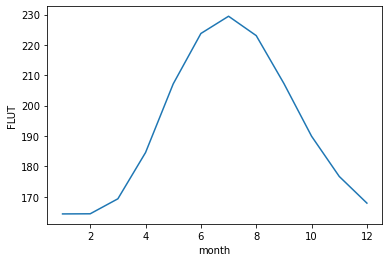

In [15]:
ensavg_olr_ds['FLUT'].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(label='ens avg')

Not using the cesm time fix works here right now. Not sure why not needed....

### Iterate over CESM1 ensemble members and variables of interest

In [16]:
cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

In [17]:
# hardcoded alternate with only ensembles we can use
ensemble_nums = [
    '001', '002', '003', '004', '005', 
    '006', '007', '008', '009', '010',
    '011', '012', '013', '014', '015',
    '016', '017', '018', '019', '020',
    '021', '022', '023', '024', '025', 
    '026', '027', '028', '029', '030', 
    '031', '032', '033', '034', '035', 
    '101', '102', '103', '104', '105'
]

#### Collect all paths in a dictionary

In [18]:
path_dict = {} # key is the ensemble number
_var = 'FLUT'

for _ensn in ensemble_nums:
    _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.1??001-200512.nc' % (cesmle_path,_var,_ensn,_var))
    _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-2???12.nc' % (cesmle_path,_var,_ensn,_var))

    if (len(_t1_file) != 1) or (len(_t2_file) != 1):
        print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
        break
    # try:
    path_dict[_ensn] = [*_t1_file,*_t2_file]
    # except:
    #     path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}    

#### Demonstrate broken fix_cesm_time code. (not sure why)

In [56]:
ensavg_olr_paths = glob.glob('%s/*FLUT*.nc' % (ensavg_path)) # get appropriate files

_ensavg_olr_preproc = xr.open_mfdataset(ensavg_olr_paths)

In [57]:
_ens_olr_testfiles = path_dict['001']

_ens_olr_testds = xr.open_mfdataset(_ens_olr_testfiles)

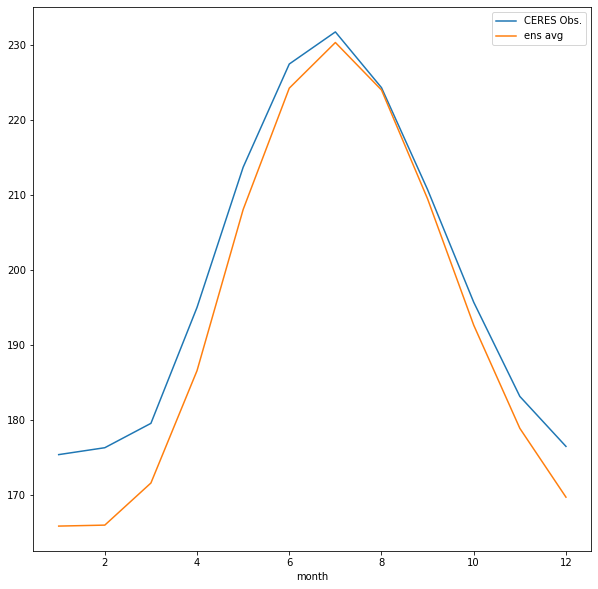

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

# _ens_olr_testds['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(ax=ax,label='Ens. Mem. 001')
# fix_cesm_time(_ens_olr_testds)['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(ax=ax,label='Ens. Mem. 001 (fixed)')

# ceres_subset.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(ax=ax,label='CERES Obs.')
ceres_subset_monavg.plot(ax=ax,label='CERES Obs.')

# _ensavg_olr_preproc['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(label='ens avg')
ensavg_subset_monavg.plot(label='ens avg')

# fix_cesm_time(_ensavg_olr_preproc)['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(label='ens avg (bad fix)')

plt.legend()

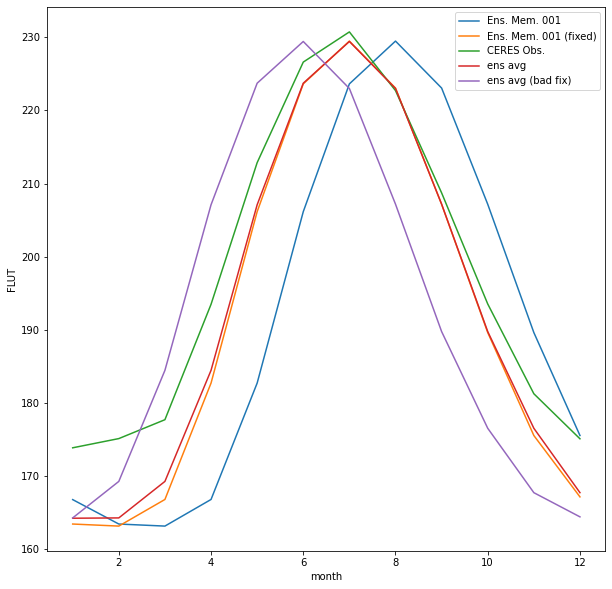

In [58]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

_ens_olr_testds['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(ax=ax,label='Ens. Mem. 001')
fix_cesm_time(_ens_olr_testds)['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(ax=ax,label='Ens. Mem. 001 (fixed)')

# ceres_subset.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(ax=ax,label='CERES Obs.')
ceres_subset_monavg.plot(ax=ax,label='CERES Obs.')

# _ensavg_olr_preproc['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(label='ens avg')
ensavg_subset_monavg.plot(label='ens avg')

fix_cesm_time(_ensavg_olr_preproc)['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(label='ens avg (bad fix)')

plt.legend()

#### Calculate an Arctic jfm OLR timeseries for each member in the CESM1-LE

Nothing is changing. Are CESM1-LE files corrected now? Why don't they agree with the data I processed previously then? What is a good simple test? Looking at the month where OLR is at a minimum?

This is slow, but does a good job not building up memory. Applying Dask here would be ideal.

In [19]:
%%time

ens_olr_jfm_tseries_dict = {}
ens_olr_ond_tseries_dict = {}
ens_olr_mon_tseries_dict = {}

for _ens_num in ensemble_nums: # iterate over ensemble members
    print(_ens_num,end=' ')
    
    _ens_olr_files = path_dict[_ens_num]
    
    _ens_olr_ds = fix_cesm_time(xr.open_mfdataset(_ens_olr_files))['FLUT'].chunk({'lat':-1,'lon':-1}) # chunk to prep for lat-lon interpolation

    _ens_interp = _ens_olr_ds.interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF
    _ens_olr_ds.close()
    
    _ens_subset = _ens_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))
    _ens_interp.close()
    
    _ens_subset_wgtd = add_weights(_ens_subset) # add area-weighting coordinate
    _ens_subset.close()
    
    _ens_subset_spatavg = masked_average(_ens_subset_wgtd,dim=['lat','lon'],weights=_ens_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO
    _ens_subset_wgtd.close()
    
    _ens_subset_jfm = _ens_subset_spatavg.sel(time=is_jfm(_ens_subset_spatavg.time)) # select jan, feb, mar
    _ens_subset_ond = _ens_subset_spatavg.sel(time=is_ond(_ens_subset_spatavg.time)) # select jan, feb, mar

    _ens_subset_jfmavg = _ens_subset_jfm.groupby('time.year').mean('time').compute() # average into an annual timeseries, compute to avoid chunkng
    _ens_subset_ondavg = _ens_subset_ond.groupby('time.year').mean('time').compute() # average into an annual timeseries, compute to avoid chunkng
    _ens_subset_monavg = _ens_subset_spatavg.groupby('time.month').mean('time').compute() # monthly OLR averages over the CERES record
    
    _ens_subset_jfm.close()
    _ens_subset_ond.close()
    _ens_subset_spatavg.close()
    
    _ens_subset_jfmavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    _ens_subset_ondavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    _ens_subset_monavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    
    ens_olr_jfm_tseries_dict[_ens_num] = _ens_subset_jfmavg #.chunk({'year':-1,'ens':-1}) # store in proc_dict
    ens_olr_ond_tseries_dict[_ens_num] = _ens_subset_ondavg #.chunk({'year':-1,'ens':-1}) # store in proc_dict
    ens_olr_mon_tseries_dict[_ens_num] = _ens_subset_monavg #.chunk({'year':-1,'ens':-1}) # store in proc_dict
        
    # if _ens_num == '005':break
    
print('combining')
# combine along the new dimension and DECHUNK. This makes sense but slows things down ALOT
allens_jfm_tseries = xr.concat(list(ens_olr_jfm_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
allens_ond_tseries = xr.concat(list(ens_olr_ond_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
allens_mon_tseries = xr.concat(list(ens_olr_mon_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})

001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 101 102 103 104 105 combining
CPU times: user 3min 12s, sys: 57.9 s, total: 4min 9s
Wall time: 4min 59s


https://docs.dask.org/en/latest/delayed-best-practices.html

"working?" Dask approach. Breaks when I actually run it with multiple workers.

In [19]:
%%time

@dask.delayed
def load_ens(path_dict,_ens_num):
    
    _ens_olr_files = path_dict[_ens_num]
    _ens_olr_ds = fix_cesm_time(xr.open_mfdataset(_ens_olr_files))['FLUT'].chunk({'lat':-1,'lon':-1}) # chunk to prep for lat-lon interpolation
    # ^is this bad that I am opening a dask object within a .delayed call? No?
    
    return _ens_olr_ds

@dask.delayed
def process_ens(_ens_olr_ds,_interp_latlon):
    
    _ens_interp = _ens_olr_ds.interp_like(_interp_latlon.isel(time=0)) # interpolate before subsetting, could use xESMF
    _ens_olr_ds.close()
    _ens_subset = _ens_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))
    _ens_subset.close()
    _ens_subset_wgtd = add_weights(_ens_subset) # add area-weighting coordinate
    _ens_subset.close()
    _ens_subset_spatavg = masked_average(_ens_subset_wgtd,dim=['lat','lon'],weights=_ens_subset_wgtd['cell_weight'])
    _ens_subset_wgtd.close()
    
    return _ens_subset_spatavg

@dask.delayed
def compute_ens(_ens_subset_spatavg,_ens_num):
    
    _ens_subset_jfm = _ens_subset_spatavg.sel(time=is_jfm(_ens_subset_spatavg.time)) # select jan, feb, mar
    _ens_subset_ond = _ens_subset_spatavg.sel(time=is_ond(_ens_subset_spatavg.time)) # select jan, feb, mar
    _ens_subset_jfmavg = _ens_subset_jfm.groupby('time.year').mean('time') #.compute() # average into an annual timeseries, compute to avoid chunkng
    _ens_subset_ondavg = _ens_subset_ond.groupby('time.year').mean('time') #.compute() # average into an annual timeseries, compute to avoid chunkng
    _ens_subset_jfm.close()
    _ens_subset_ond.close()
    _ens_subset_monavg = _ens_subset_spatavg.groupby('time.month').mean('time') #.compute() # monthly OLR averages over the CERES record
    _ens_subset_spatavg.close()
    
    _ens_subset_jfmavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    _ens_subset_ondavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    _ens_subset_monavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    
    return _ens_subset_jfmavg,_ens_subset_monavg,_ens_subset_ondavg

def f(path_dict,ensemble_nums):
    # results = []
    results = {}
    for _ens_num in ensemble_nums:
        # print(_ens_num)
        data = load_ens(path_dict,_ens_num)
        data = process_ens(data,ceres_subset)
        result = compute_ens(data,_ens_num)

        # results.append(result)
        results[_ens_num] = result
        
        # if _ens_num == '005':break

    return results

CPU times: user 257 µs, sys: 0 ns, total: 257 µs
Wall time: 206 µs


In [20]:
%%time

preresults = f(path_dict,ensemble_nums)

CPU times: user 25.1 ms, sys: 989 µs, total: 26.1 ms
Wall time: 25.5 ms


In [22]:
%%time

results = dask.compute(preresults)[0]

KilledWorker: ('load_ens-aa00e9bd-f46c-4530-9ecf-de332b91b28c', <Worker 'tcp://127.0.0.1:35001', name: 1, memory: 0, processing: 40>)

#### Post-process into a ensemble-combined format

Only do if the dask approach is fixed.

In [57]:
ens_olr_jfm_tseries_list = []
ens_olr_ond_tseries_list = []
ens_olr_mon_tseries_list = []

for _ens_num in ensemble_nums:
    ens_olr_jfm_tseries_list.append(results[_ens_num][0])
    ens_olr_ond_tseries_list.append(results[_ens_num][0])
    ens_olr_mon_tseries_list.append(results[_ens_num][1])
    
allens_jfm_tseries = xr.concat(ens_olr_jfm_tseries_list,dim='ens') #.chunk({'year':-1,'ens':-1})
allens_ond_tseries = xr.concat(ens_olr_ond_tseries_list,dim='ens') #.chunk({'year':-1,'ens':-1})
allens_mon_tseries = xr.concat(ens_olr_mon_tseries_list,dim='ens') #.chunk({'year':-1,'ens':-1})

In [ ]:
allens_jfm_tseries = xr.concat(list(ens_olr_jfm_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
allens_ond_tseries = xr.concat(list(ens_olr_ond_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
allens_mon_tseries = xr.concat(list(ens_olr_mon_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})

#### This final plotting step is slow if I do not precompute.

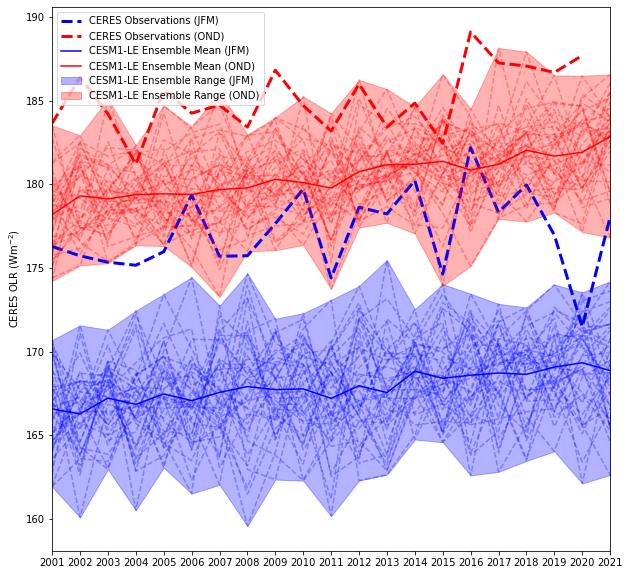

In [33]:
fig3,ax3 = plt.subplots(1,1,figsize=(10,10))

# Plot CERES data:
ax3.plot(ceres_subset_jfmavg['year'],ceres_subset_jfmavg,label='CERES Observations (JFM)',color='blue',linestyle='dashed',linewidth=3)
ax3.plot(ceres_subset_ondavg['year'],ceres_subset_ondavg,label='CERES Observations (OND)',color='red',linestyle='dashed',linewidth=3)

# Plot AIRS data:
# ax3.plot(airs_subset_jfmavg['year'],airs_subset_jfmavg,label='AIRS Broadband Observations',color='grey')
# ceres_subset_jfmavg

# Plot CESM1-LE ensemble average data
ax3.plot(ensavg_subset_jfmavg['year'],ensavg_subset_jfmavg,label='CESM1-LE Ensemble Mean (JFM)',color='blue')
ax3.plot(ensavg_subset_ondavg['year'],ensavg_subset_ondavg,label='CESM1-LE Ensemble Mean (OND)',color='red')

# calculate ensemble maximum and minimum values at each timestep, this shouldn't be so slow but maybe all the operations are dask.delayed...
lens_max_jfm = allens_jfm_tseries.max(dim='ens').values # speeds up somewhat. My code must be bad somewhere...
lens_min_jfm = allens_jfm_tseries.min(dim='ens').values
lens_avg_jfm = allens_jfm_tseries.mean(dim='ens').values

lens_max_ond = allens_ond_tseries.max(dim='ens').values 
lens_min_ond = allens_ond_tseries.min(dim='ens').values
lens_avg_ond = allens_ond_tseries.mean(dim='ens').values

# ax3.plot(allens_jfm_tseries['year'],lens_avg,label='CESM1-LE Ensemble Mean (alt)',color='green')


ax3.fill_between(x=allens_jfm_tseries['year'],y1=lens_min_jfm,y2=lens_max_jfm,label='CESM1-LE Ensemble Range (JFM)',color='blue',alpha=0.3)
ax3.fill_between(x=allens_ond_tseries['year'],y1=lens_min_ond,y2=lens_max_ond,label='CESM1-LE Ensemble Range (OND)',color='red',alpha=0.3)

for _ens_tseries in allens_jfm_tseries: # iterate over ensembles
    ax3.plot(_ens_tseries['year'],_ens_tseries,alpha=0.3,linestyle='dashed',color='blue') 
    
for _ens_tseries in allens_ond_tseries: # iterate over ensembles
    ax3.plot(_ens_tseries['year'],_ens_tseries,alpha=0.3,linestyle='dashed',color='red')
    

# for _ens_num in ens_olr_jfm_tseries_dict: # alternate faster iterate over ensembles
#     ax3.plot(ens_olr_jfm_tseries_dict[_ens_num]['year'],ens_olr_jfm_tseries_dict[_ens_num],alpha=0.2,linestyle='dashed',color='blue') 

ax3.set_ylabel('CERES OLR (Wm$^{-2}$)')
_out = ax3.set_xticks(ensavg_subset_jfmavg['year']) # this is weird and returns something if it's the last line in a cell
ax3.set_xlim(2001,2021)

plt.legend()

### Now plot box-and-whisker plots for different end years

In [26]:
endyrs = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

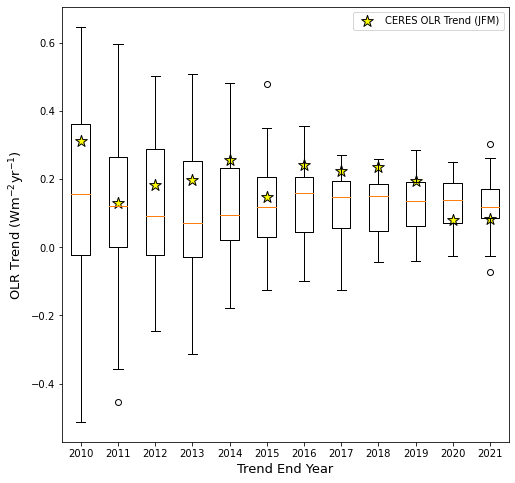

In [27]:
box_fig,box_ax = plt.subplots(1,1,figsize=(8,8))

ceres_slopes = []
esn_slopes_dict = {}

for _yr in endyrs:

    ceres_tseries_concated = ceres_subset_jfmavg.sel(year=slice(None,_yr))
    cesm_tseries_concated = allens_jfm_tseries.sel(year=slice(None,_yr))

    ceres_polyfit = ceres_tseries_concated.polyfit(dim='year',deg=1)
    cesm_polyfit = cesm_tseries_concated.polyfit(dim='year',deg=1)

    ceres_slope = ceres_polyfit['polyfit_coefficients'].sel(degree=1).values
    cesm_slopes = cesm_polyfit['polyfit_coefficients'].sel(degree=1).values
    
    ceres_slopes.append(ceres_slope)
    esn_slopes_dict[_yr] = cesm_slopes

box_out = plt.boxplot(esn_slopes_dict.values(), labels=endyrs)
plt.scatter(np.arange(1,13,1),ceres_slopes,label='CERES OLR Trend (JFM)',marker='*',color='yellow',edgecolors= "black",s=150)

box_ax.set_xlabel('Trend End Year',fontsize=13)
box_ax.set_ylabel('OLR Trend (Wm$^{-2}$yr$^{-1}$)',fontsize=13)

ax_sigb = ax_sig.twiny() 
# Twinning the axis doesn't copy over everything apparently. Need to copy tick values.
ax_sigb.set_xlim(ax_sig.get_xlim())
ax_sigb.set_xticks(ax_sig.get_xticks())

plt.legend()

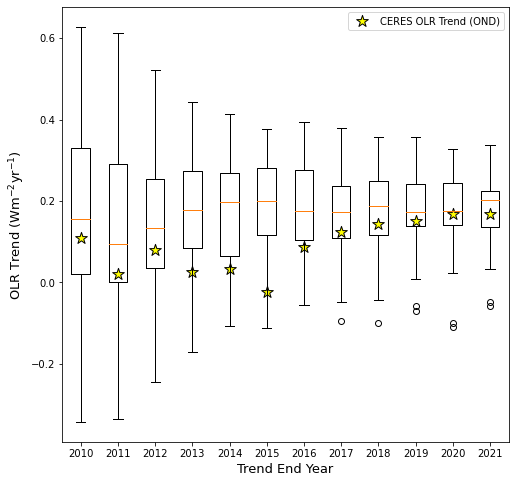

In [28]:
box_fig,box_ax = plt.subplots(1,1,figsize=(8,8))

ceres_slopes = []
esn_slopes_dict = {}

for _yr in endyrs:

    ceres_tseries_concated = ceres_subset_ondavg.sel(year=slice(None,_yr))
    cesm_tseries_concated = allens_ond_tseries.sel(year=slice(None,_yr))

    ceres_polyfit = ceres_tseries_concated.polyfit(dim='year',deg=1)
    cesm_polyfit = cesm_tseries_concated.polyfit(dim='year',deg=1)

    ceres_slope = ceres_polyfit['polyfit_coefficients'].sel(degree=1).values
    cesm_slopes = cesm_polyfit['polyfit_coefficients'].sel(degree=1).values
    
    ceres_slopes.append(ceres_slope)
    esn_slopes_dict[_yr] = cesm_slopes

box_out = plt.boxplot(esn_slopes_dict.values(), labels=endyrs)
plt.scatter(np.arange(1,13,1),ceres_slopes,label='CERES OLR Trend (OND)',marker='*',color='yellow',edgecolors= "black",s=150)

box_ax.set_xlabel('Trend End Year',fontsize=13)
box_ax.set_ylabel('OLR Trend (Wm$^{-2}$yr$^{-1}$)',fontsize=13)

plt.legend()

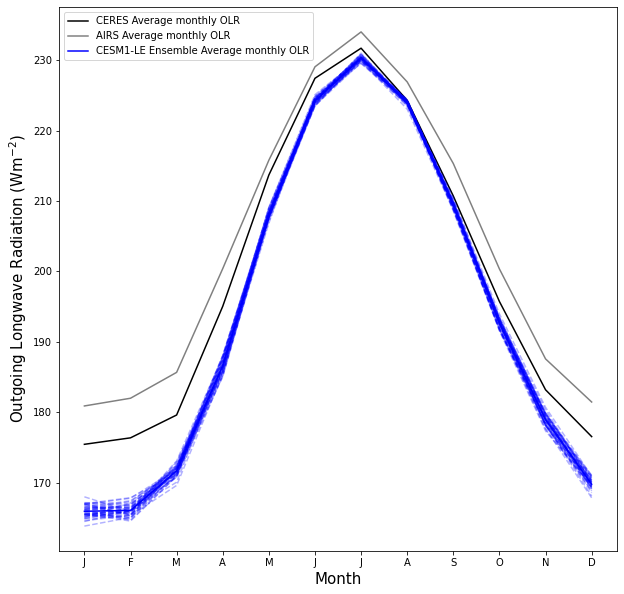

In [101]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

plt.plot(ceres_subset_monavg['month'],ceres_subset_monavg,label='CERES Average monthly OLR',color='black')
plt.plot(airs_subset_monavg['month'],airs_subset_monavg,label='AIRS Average monthly OLR',color='grey')

plt.plot(ensavg_subset_monavg['month'],ensavg_subset_monavg,label='CESM1-LE Ensemble Average monthly OLR',color='blue')

for _ens_tseries in allens_mon_tseries: # iterate over ensembles
    ax.plot(_ens_tseries['month'],_ens_tseries,alpha=0.3,linestyle='dashed',color='blue') 

ax.set_ylabel('Outgoing Longwave Radiation (Wm$^{-2}$)',fontsize=15)
ax.set_xlabel('Month',fontsize=15)
xticks = ax.set_xticks(np.arange(1,13,1))
xticks_labels = ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

plt.legend()